## The project: Cluster Profiling

This project focuses on analyzing and understanding patterns in network traffic data using unsupervised clustering techniques.

### Goal

To automatically group similar network flows (NetFlow records) into clusters and generate meaningful, human-readable insights that describe the behavior of each cluster.

### Dataset

The dataset contains sampled NetFlow records with various network features, including packet counts, byte counts, ports, protocols, and time-related fields.

### Applications

* Identifying suspicious behavior in large volumes of network data
* Supporting cybersecurity threat hunting
* Exploring hidden patterns in unlabeled traffic logs


## The Dataset: netflow_sampling_250_50-50_train.csv

This dataset contains sampled **NetFlow records**, where each row represents a **network flow** (i.e., a unidirectional sequence of packets sharing the same source, destination, protocol, ports, etc.).

The name `250_50-50_train` likely refers to:

* NetFlow sampled at 1:250 rate
* 50% benign / 50% malicious traffic
* Train set for classification or clustering

---

## Column Descriptions

| Column Name   | Description                                                                                                       |
| ------------- | ----------------------------------------------------------------------------------------------------------------- |
| `#:unix_secs` | Unix timestamp (seconds) of the flow start (epoch time).                                                          |
| `unix_nsecs`  | Nanoseconds portion of the timestamp.                                                                             |
| `sysuptime`   | Router system uptime (milliseconds) at the time the flow was exported.                                            |
| `exaddr`      | IP address of the exporter (the device that generated the NetFlow record).                                        |
| `dpkts`       | Number of packets in the flow.                                                                                    |
| `doctets`     | Total number of bytes in the flow (octets).                                                                       |
| `first`       | Time (in ms since boot) the first packet of the flow was seen.                                                    |
| `last`        | Time (in ms since boot) the last packet of the flow was seen.                                                     |
| `engine_type` | Type of flow engine (e.g., packet-based or byte-based).                                                           |
| `engine_id`   | ID of the flow engine on the exporter device.                                                                     |
| `srcaddr`     | Source IP address of the flow.                                                                                    |
| `dstaddr`     | Destination IP address of the flow.                                                                               |
| `nexthop`     | IP address of the next hop router (used in routing analysis).                                                     |
| `input`       | SNMP index of the input interface (on the exporter).                                                              |
| `output`      | SNMP index of the output interface (on the exporter).                                                             |
| `srcport`     | Source port of the connection (e.g., 443 for HTTPS).                                                              |
| `dstport`     | Destination port of the connection (e.g., 80 for HTTP).                                                           |
| `prot`        | Protocol used (e.g., 6 for TCP, 17 for UDP, 1 for ICMP).                                                          |
| `tos`         | Type of Service field from the IP header (used for QoS).                                                          |
| `tcp_flags`   | Cumulative OR of TCP flags seen in the flow (e.g., SYN, FIN, ACK, etc.).                                          |
| `src_mask`    | Subnet mask (CIDR bits) of the source IP (e.g., 24 = 255.255.255.0).                                              |
| `dst_mask`    | Subnet mask of the destination IP.                                                                                |
| `src_as`      | Source Autonomous System number (BGP-related).                                                                    |
| `dst_as`      | Destination Autonomous System number.                                                                             |
| `Label`       | The class label of the flow: **benign** or **malicious** (or specific attack type, depending on dataset version). |

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Portfolio datasets/cyber/netflow_sampling_250_50-50_train.csv')

# Show all column names and a small sample
print("Available columns:")
print(df.columns.tolist())
df.head(3)


Available columns:
['#:unix_secs', 'unix_nsecs', 'sysuptime', 'exaddr', 'dpkts', 'doctets', 'first', 'last', 'engine_type', 'engine_id', 'srcaddr', 'dstaddr', 'nexthop', 'input', 'output', 'srcport', 'dstport', 'prot', 'tos', 'tcp_flags', 'src_mask', 'dst_mask', 'src_as', 'dst_as', 'Label']


,#:unix_secs,unix_nsecs,sysuptime,exaddr,dpkts,doctets,first,last,engine_type,engine_id,...,srcport,dstport,prot,tos,tcp_flags,src_mask,dst_mask,src_as,dst_as,Label
0,1589564560,434751,34918548,182.168.1.1,1,1492,34885432,34885432,0,0,...,496,40250,6,0,16,0,0,0,0,0
1,1589564560,434751,34918548,182.168.1.1,1,1492,34885692,34885692,0,0,...,254,38600,6,0,16,0,0,0,0,0
2,1589564560,434751,34918548,182.168.1.1,1,52,34885664,34885664,0,0,...,38600,443,6,0,16,0,0,0,0,0


## Cluster Profiling Code Explanation

This code performs **unsupervised clustering** on a NetFlow dataset in order to discover patterns and structure in network traffic.

---

### Part 1: Elbow Method for KMeans

This section helps determine the optimal number of clusters (`k`) for KMeans using the **Elbow Method**.

#### Steps:

1. **Load the NetFlow dataset**.
2. **Feature engineering**:

   * `duration = last - first`
   * `bytes_per_pkt = doctets / (dpkts + 1)`
3. **Select relevant features** (packet/byte counts, ports, protocol, etc.).
4. **Standardize the features** using `StandardScaler`.
5. **Train KMeans** for different values of `k` (from 2 to 9).
6. **Plot the inertia (WCSS)** to find the "elbow" — the point where adding more clusters doesn’t significantly reduce intra-cluster distance.

---



### Part 2: Clustering and Evaluation

This section applies and compares several clustering algorithms and evaluates them using common unsupervised metrics.

#### Algorithms Used:

* **KMeans** (k = 3 and 4)
* **DBSCAN**
* **Gaussian Mixture Models (GMM)** (k = 4)
* **Agglomerative Clustering** (k = 4)
* **OPTICS**

#### Feature Engineering:

Same as above:

* Duration and bytes per packet are derived features.

#### Evaluation Metrics:

Each clustering method is evaluated using the following metrics:

* **Silhouette Score** – cohesion vs. separation
* **Davies-Bouldin Index** – lower is better
* **Calinski-Harabasz Score** – higher is better
* **Dunn Index** – higher indicates better separation
* **BetaCV** – ratio of intra- to inter-cluster distances
* **WCSS** – Within-Cluster Sum of Squares (for KMeans)

#### Outputs:

* All cluster labels are added as new columns to the original DataFrame (`kmeans_3`, `dbscan`, etc.).
* The DataFrame is saved to `netflow_with_all_clusters.csv` for further analysis.


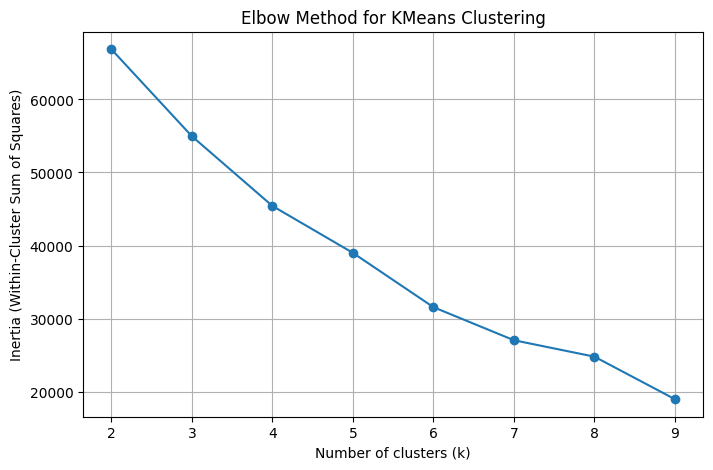

In [6]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('/content/drive/MyDrive/Portfolio datasets/cyber/netflow_sampling_250_50-50_train.csv')

# Feature engineering based on available columns
df['duration'] = df['last'] - df['first']
df['bytes_per_pkt'] = df['doctets'] / (df['dpkts'] + 1)

# Fill NaNs and select features
features = ['dpkts', 'doctets', 'srcport', 'dstport', 'prot', 'tcp_flags', 'duration', 'bytes_per_pkt']
X = df[features].fillna(0)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method
inertias = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.grid(True)
plt.show()


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    pairwise_distances
)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, OPTICS
from scipy.spatial.distance import cdist
import warnings

# === Suppress RuntimeWarnings (e.g., from OPTICS divide by zero) ===
warnings.filterwarnings("ignore", category=RuntimeWarning)

# === Load dataset ===
df = pd.read_csv('/content/drive/MyDrive/Portfolio datasets/cyber/netflow_sampling_250_50-50_train.csv')
df['duration'] = df['last'] - df['first']
df['bytes_per_pkt'] = df['doctets'] / (df['dpkts'] + 1)

features = ['dpkts', 'doctets', 'srcport', 'dstport',
            'prot', 'tcp_flags', 'duration', 'bytes_per_pkt']

X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# === Metrics ===
def dunn_index(X, labels):
    unique = np.unique(labels)
    unique = unique[unique != -1]
    if len(unique) < 2:
        return np.nan
    intra, inter = [], []
    for i in unique:
        xi = X[labels == i]
        if len(xi) > 1:
            intra.append(np.max(cdist(xi, xi)))
        for j in unique:
            if i < j:
                xj = X[labels == j]
                inter.append(np.min(cdist(xi, xj)))
    return np.min(inter) / np.max(intra)

def beta_cv(X, labels):
    D = pairwise_distances(X)
    intra, inter = [], []
    for i in np.unique(labels):
        if i == -1:
            continue
        idx = np.where(labels == i)[0]
        if len(idx) > 1:
            intra_d = D[np.ix_(idx, idx)]
            intra.append(np.mean(intra_d[np.triu_indices_from(intra_d, k=1)]))
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            if labels[i] != labels[j] and labels[i] != -1 and labels[j] != -1:
                inter.append(D[i, j])
    return np.mean(intra) / np.mean(inter)

def compute_wcss(X, labels, centroids):
    wcss = 0.0
    for i in np.unique(labels):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            wcss += np.sum((cluster_points - centroids[i]) ** 2)
    return wcss

def evaluate_all(X, labels, name, centroids=None):
    print(f"\n=== {name} ===")
    if len(np.unique(labels)) <= 1 or np.all(labels == -1):
        print("Not enough clusters.")
        return
    print(f"Silhouette Score        : {silhouette_score(X, labels):.3f}")
    print(f"Davies-Bouldin Index    : {davies_bouldin_score(X, labels):.3f}")
    print(f"Calinski-Harabasz Score : {calinski_harabasz_score(X, labels):.1f}")
    print(f"Dunn Index              : {dunn_index(X, labels):.3f}")
    if centroids is not None:
        print(f"Within-Cluster SS (WCSS): {compute_wcss(X, labels, centroids):.2f}")
    print(f"BetaCV                  : {beta_cv(X, labels):.3f}")

# === KMeans (k=3)
kmeans3 = KMeans(n_clusters=3, random_state=42)
labels_k3 = kmeans3.fit_predict(X_scaled)
df['kmeans_3'] = labels_k3
evaluate_all(X_scaled, labels_k3, "KMeans (k=3)", centroids=kmeans3.cluster_centers_)

# === KMeans (k=4)
kmeans4 = KMeans(n_clusters=4, random_state=42)
labels_k4 = kmeans4.fit_predict(X_scaled)
df['kmeans_4'] = labels_k4
evaluate_all(X_scaled, labels_k4, "KMeans (k=4)", centroids=kmeans4.cluster_centers_)

# === DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)
df['dbscan'] = labels_dbscan
if np.sum(labels_dbscan != -1) > 1:
    evaluate_all(X_scaled[labels_dbscan != -1], labels_dbscan[labels_dbscan != -1], "DBSCAN (excluding noise)")

# === GMM (k=4)
gmm = GaussianMixture(n_components=4, random_state=42)
labels_gmm = gmm.fit_predict(X_scaled)
df['gmm'] = labels_gmm
evaluate_all(X_scaled, labels_gmm, "Gaussian Mixture (k=4)")

# === Agglomerative
agglo = AgglomerativeClustering(n_clusters=4)
labels_agglo = agglo.fit_predict(X_scaled)
df['agglo'] = labels_agglo
evaluate_all(X_scaled, labels_agglo, "Agglomerative Clustering (k=4)")

# === OPTICS
optics = OPTICS(min_samples=10)
labels_optics = optics.fit_predict(X_scaled)
df['optics'] = labels_optics
if np.sum(labels_optics != -1) > 1:
    evaluate_all(X_scaled[labels_optics != -1], labels_optics[labels_optics != -1], "OPTICS (excluding noise)")

# === Save
df.to_csv("netflow_with_all_clusters.csv", index=False)
print("\nSaved: netflow_with_all_clusters.csv")



=== KMeans (k=3) ===
Silhouette Score        : 0.284
Davies-Bouldin Index    : 1.352
Calinski-Harabasz Score : 2686.2
Dunn Index              : 0.000
Within-Cluster SS (WCSS): 54967.95
BetaCV                  : 0.881

=== KMeans (k=4) ===
Silhouette Score        : 0.343
Davies-Bouldin Index    : 1.124
Calinski-Harabasz Score : 2896.4
Dunn Index              : 0.000
Within-Cluster SS (WCSS): 45422.00
BetaCV                  : 0.700

=== DBSCAN (excluding noise) ===
Silhouette Score        : 0.283
Davies-Bouldin Index    : 1.054
Calinski-Harabasz Score : 1360.2
Dunn Index              : 0.146
BetaCV                  : 0.442

=== Gaussian Mixture (k=4) ===
Silhouette Score        : 0.252
Davies-Bouldin Index    : 1.584
Calinski-Harabasz Score : 1828.3
Dunn Index              : 0.000
BetaCV                  : 0.612

=== Agglomerative Clustering (k=4) ===
Silhouette Score        : 0.427
Davies-Bouldin Index    : 0.888
Calinski-Harabasz Score : 2784.4
Dunn Index              : 0.002
BetaCV 

## Clustering Evaluation Summary

This section presents the results of six clustering algorithms applied to NetFlow data.  
Each method was evaluated using common unsupervised clustering metrics.

---

### KMeans (k=3 and k=4)
- **KMeans (k=4)** outperforms k=3 in all metrics:
  - Higher Silhouette (0.343)
  - Lower DBI (1.124)
  - Higher CHI (2896.4)
  - Lower WCSS (45422)
- However, **Dunn Index is 0** in both, indicating overlapping or poorly separated clusters.
- **BetaCV** values are relatively high (weak inter-cluster separation).

---

### DBSCAN (excluding noise)
- Detects noise and forms density-based clusters.
- Moderate scores across all metrics.
- **Dunn Index (0.146)** and **BetaCV (0.442)** suggest better separation than KMeans.
- Still limited by sensitivity to `eps`.

---

### Gaussian Mixture Model (GMM)
- Produces soft probabilistic clusters.
- Lowest Silhouette (0.252) and highest DBI (1.584), indicating poor separation.
- Performs worse than KMeans or DBSCAN.

---

### Agglomerative Clustering (k=4)
- **Silhouette Score** is 0.427, better than all above.
- **DBI (0.888)** and **CHI (2784.4)** also competitive.
- Slight improvement in **Dunn Index (0.002)** and **BetaCV (0.659)**.

---

### OPTICS (excluding noise)
- **Best overall performance**:
  - Highest Silhouette Score: **0.630**
  - Lowest DBI: **0.524**
  - Highest CHI: **3899.2**
  - Lowest BetaCV: **0.030**
- Identifies well-separated clusters and noise.
- Despite a low Dunn Index, all other metrics strongly favor this method.

---

### Conclusion
**OPTICS** clearly provides the best clustering results on this dataset,  
showing strong compactness and separation with support for noise detection.


## PCA Visualization of OPTICS Clusters (best clustering model)

This code visualizes the structure of network traffic clusters using **Principal Component Analysis (PCA)** and **OPTICS clustering** results.

### Steps:

1. **Load clustered data**
   Reads the NetFlow dataset after clustering (`netflow_with_all_clusters.csv`).

2. **Select and scale features**
   Uses features like packet/byte counts, ports, and duration. Data is standardized with `StandardScaler`.

3. **Apply PCA**
   Reduces dimensionality to 2 components to make the data easier to plot.

4. **Filter clusters**

   * Option 1: Keep only clusters with **at least 30 samples**. Smaller clusters are marked as -99 ("Other").
   * Option 2: Keep only the **Top N largest clusters** (e.g., Top 10). The rest are labeled "Other".

5. **Visualize clusters (scatter plot)**
   Plots the PCA result using color to represent each cluster. Makes it easy to see separation or overlap between clusters.

6. **Plot cluster distribution (bar chart)**
   Shows how many samples each cluster contains, helping understand cluster sizes and dominance.


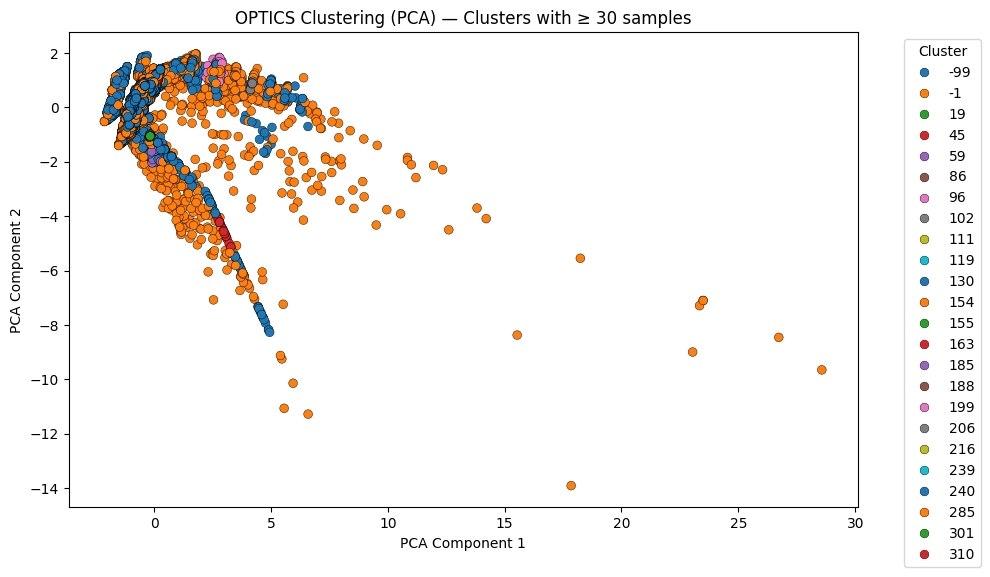

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the clustered dataset
df = pd.read_csv("netflow_with_all_clusters.csv")

# Select the same features used for clustering
features = ['dpkts', 'doctets', 'srcport', 'dstport',
            'prot', 'tcp_flags', 'duration', 'bytes_per_pkt']
X = df[features].fillna(0)

# Normalize the features
X_scaled = StandardScaler().fit_transform(X)

# Perform PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Count how many samples per cluster
cluster_counts = df['optics'].value_counts()

# Keep only clusters with ≥ 30 samples
valid_clusters = cluster_counts[cluster_counts >= 30].index

# Mark small clusters as -99 ("Other")
df['optics_display'] = df['optics'].where(df['optics'].isin(valid_clusters), -99)

# Plot the PCA result with filtered clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['optics_display'],
    palette='tab10',
    s=40,
    edgecolor='k',
    linewidth=0.3
)

plt.title("OPTICS Clustering (PCA) — Clusters with ≥ 30 samples")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


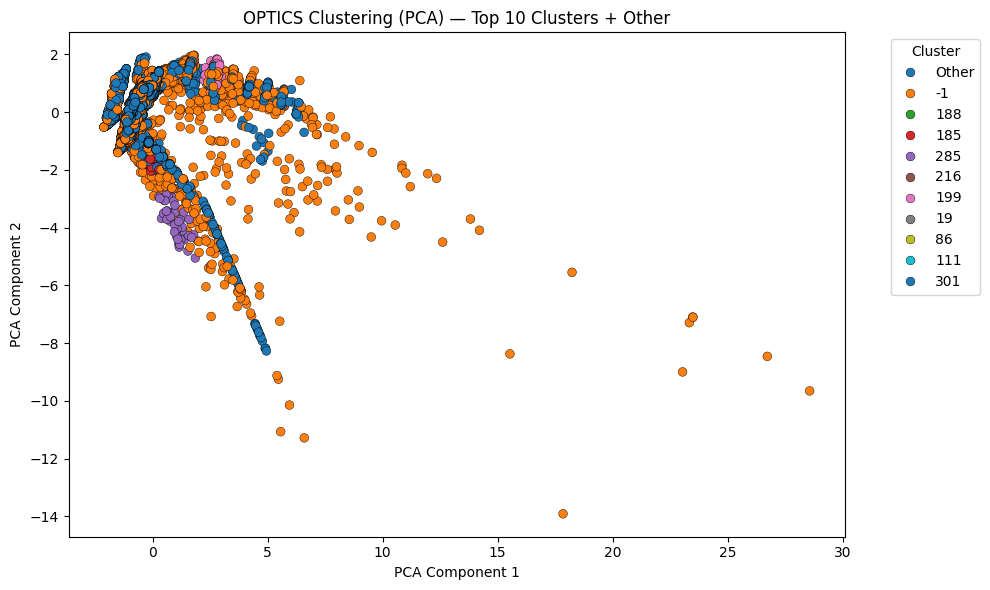

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load clustered dataset
df = pd.read_csv("netflow_with_all_clusters.csv")

# Select features used in clustering
features = ['dpkts', 'doctets', 'srcport', 'dstport',
            'prot', 'tcp_flags', 'duration', 'bytes_per_pkt']
X = df[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

# PCA for 2D projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Keep only Top-N largest clusters ---
N = 10  # Top N clusters to keep
top_clusters = df['optics'].value_counts().head(N).index

# Replace small clusters with 'Other'
df['optics_topN'] = df['optics'].where(df['optics'].isin(top_clusters), 'Other')

# Convert all labels to string for cleaner legend
df['optics_topN'] = df['optics_topN'].astype(str)

# Plot the PCA result with Top-N clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['optics_topN'],
    palette='tab10',
    s=40,
    edgecolor='k',
    linewidth=0.3
)

plt.title(f"OPTICS Clustering (PCA) — Top {N} Clusters + Other")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



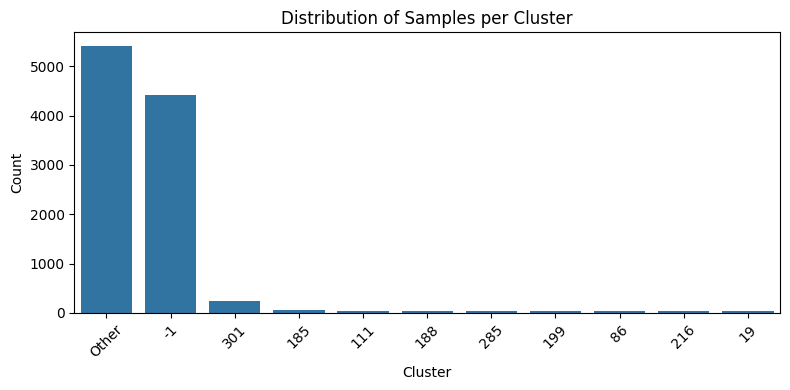

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x='optics_topN', data=df, order=df['optics_topN'].value_counts().index)
plt.title("Distribution of Samples per Cluster")
plt.ylabel("Count")
plt.xlabel("Cluster")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Cluster Feature Profiling and Explanation

This part of the project analyzes each cluster by comparing its average feature values to the global dataset, using **Z-scores**, and generates automatic textual insights.

### What the Code Does:

1. **Select the top N clusters**
   Keeps the largest clusters (e.g., top 10), and groups the rest under `"Other"`.

2. **Compute Z-scores per cluster**
   For each feature in each cluster, compute how far its mean deviates from the global mean (in standard deviations).

3. **Visualize Z-scores (heatmap)**
   Displays a heatmap of feature Z-scores per cluster to quickly spot anomalies or dominant behaviors.

4. **Generate automatic explanations**
   Based on the Z-scores, generate a descriptive sentence for each cluster:

   * If there are strong high/low features → describe them.
   * Otherwise → list the two most distinct features.

---

This step turns raw clusters into **human-readable profiles**, helping analysts quickly understand what makes each cluster unique.


## What is Z-Score?

A **Z-Score** (also known as *standard score*) measures how far a specific value is from the overall mean, expressed in units of standard deviation.

### Formula:

[
Z = \frac{x - \mu}{\sigma}
]

Where:

* ( x ): the value from the cluster (e.g., average duration in cluster)
* ( \mu ): the global mean of the feature
* ( \sigma ): the global standard deviation of the feature

---

## What Does Z-Score Tell Us?

| Z-Score | Interpretation                       |
| ------- | ------------------------------------ |
| 0       | Exactly average                      |
| +1.0    | One standard deviation above average |
| +2.0    | Significantly high                   |
| -1.0    | One standard deviation below average |
| -2.0    | Significantly low                    |

---

## Why Is Z-Score Useful in Clustering?

When we compute the average feature values within a cluster and compare them to the entire dataset, the Z-Score helps us:

* Detect whether a feature is **significantly high or low** in the cluster.
* Understand whether the cluster represents **unusual or distinct behavior**.

---

## Example

Suppose in the full dataset:

* Mean of `duration` = 100
* Standard deviation of `duration` = 30

And in a specific cluster:

* Mean `duration` = 160

Then:

[
Z = \frac{160 - 100}{30} = 2.0
]

This means the average connection duration in this cluster is **2 standard deviations above the global mean**.

**Interpretation**: This cluster may represent **persistent services** or a **long-running attack**.

---

## Why Use Z-Score Instead of Raw Averages?

Different features have different scales:

* `duration` might range from seconds to hours.
* `dpkts` (packet count) could range from 1 to 10000.

Z-Score **normalizes all features** onto the same scale, making comparisons fair and meaningful across all features.



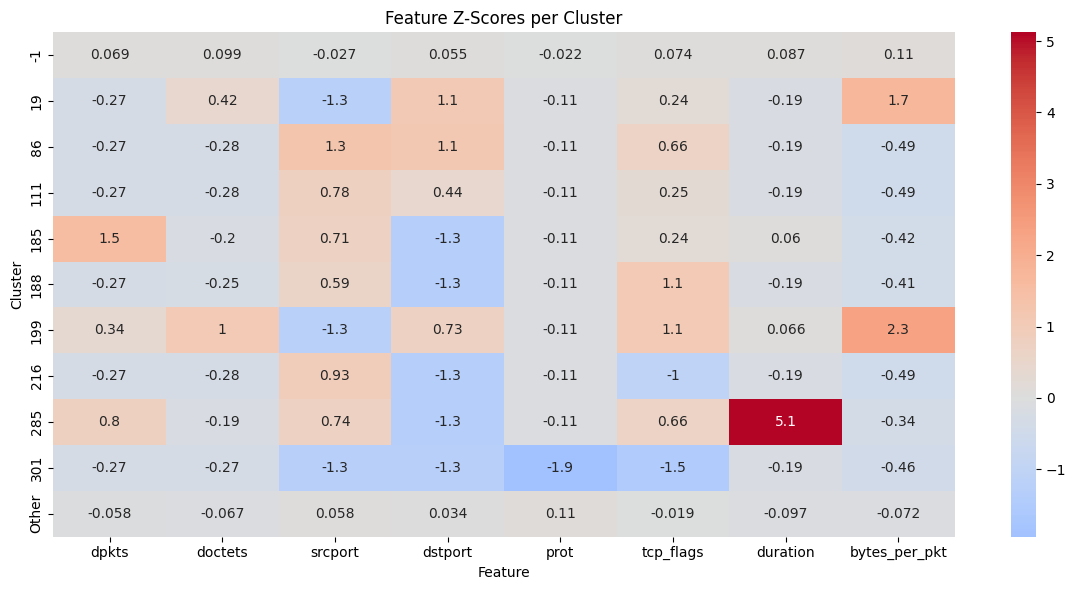

In [ ]:
import seaborn as sns

global_means = df[features].mean()
global_stds = df[features].std()

def cluster_z_scores(cluster_df):
    return (cluster_df[features].mean() - global_means) / global_stds

# Temporarily drop the group column from inside
z_df = (
    df.drop(columns=['optics_topN'])  # remove grouping col
      .groupby(df['optics_topN'])
      .apply(cluster_z_scores)
      .fillna(0)
)


z_df = z_df.fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(z_df, annot=True, cmap='coolwarm', center=0)
plt.title("Feature Z-Scores per Cluster")
plt.ylabel("Cluster")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


In [9]:
import pandas as pd
import numpy as np

# === Load NetFlow with OPTICS clusters ===
df = pd.read_csv("netflow_with_all_clusters.csv")

# === Define feature columns ===
features = ['dpkts', 'doctets', 'srcport', 'dstport',
            'prot', 'tcp_flags', 'duration', 'bytes_per_pkt']

# === Create 'optics_topN' column for top N clusters ===
N = 10
top_clusters = df['optics'].value_counts().head(N).index
df['optics_topN'] = df['optics'].where(df['optics'].isin(top_clusters), 'Other')

# === Compute global mean and std for Z-score ===
global_mean = df[features].mean()
global_std = df[features].std()

# === Compute Z-score per cluster ===
def cluster_z_scores(sub_df):
    return (sub_df[features].mean() - global_mean) / global_std

z_scores = (
    df.drop(columns=['optics_topN'])  # remove group column from the DataFrame
      .groupby(df['optics_topN'])     # group externally
      .apply(cluster_z_scores)
      .fillna(0)
)

# === Extract deviations per cluster ===
cluster_insights = {}
for cluster_id, row in z_scores.iterrows():
    high_feats = row[row > 1.5].sort_values(ascending=False)
    low_feats = row[row < -1.5].sort_values()
    cluster_insights[cluster_id] = {
        "high": list(high_feats.items()),
        "low": list(low_feats.items()),
        "row_z": row  # pass full z-row for fallback
    }

# === Insight generator ===
def generate_insight_paragraph(cluster_id, info):
    row_z = info.get("row_z", pd.Series(dtype=float))
    high_feats = info["high"]
    low_feats = info["low"]

    if high_feats and low_feats:
        highs = ", ".join([f"{k} (Z={v:.1f})" for k, v in high_feats])
        lows = ", ".join([f"{k} (Z={v:.1f})" for k, v in low_feats])
        return f"This cluster exhibits significantly elevated values in: {highs}, along with notably low values in: {lows}."

    elif high_feats and not low_feats:
        highs = ", ".join([f"{k} (Z={v:.1f})" for k, v in high_feats])
        return f"This cluster is primarily characterized by high values in: {highs}."

    elif low_feats and not high_feats:
        lows = ", ".join([f"{k} (Z={v:.1f})" for k, v in low_feats])
        return f"This cluster stands out due to its low values in: {lows}."

    elif not row_z.empty:
        top_diff = row_z.abs().sort_values(ascending=False).head(2)
        phrases = [f"{feat} (Z={row_z[feat]:.2f})" for feat in top_diff.index]
        return f"This cluster does not contain strong outliers, but its most distinct features are: {', '.join(phrases)}."

    else:
        return "This cluster does not show meaningful deviation from the global averages."


# === Generate insights ===
rows = []
for cid, info in cluster_insights.items():
    insight = generate_insight_paragraph(cid, info)
    rows.append({"cluster": cid, "insight": insight})

insights_df = pd.DataFrame(rows)
insights_df.to_csv("cluster_insights_llm.csv", index=False)

# === Preview
pd.set_option('display.max_colwidth', None)
print("Sample insights:\n")
print(insights_df.head(10).to_string(index=False))



Sample insights:

cluster                                                                                                                       insight
     -1  This cluster does not contain strong outliers, but its most distinct features are: bytes_per_pkt (Z=0.11), doctets (Z=0.10).
     19                                             This cluster is primarily characterized by high values in: bytes_per_pkt (Z=1.7).
     86        This cluster does not contain strong outliers, but its most distinct features are: srcport (Z=1.28), dstport (Z=1.13).
    111 This cluster does not contain strong outliers, but its most distinct features are: srcport (Z=0.78), bytes_per_pkt (Z=-0.49).
    185                                                     This cluster is primarily characterized by high values in: dpkts (Z=1.5).
    188     This cluster does not contain strong outliers, but its most distinct features are: dstport (Z=-1.32), tcp_flags (Z=1.09).
    199                                     

## Output Description: Cluster Insight Table

The output is a **table with a natural-language description for each cluster** in the dataset.

For each cluster, the table shows:

* **Cluster number** (e.g., `-1`, `19`, `285`, etc.)
* **An insight paragraph** that describes what characterizes the cluster in simple language.

### Example Entries:

* **Cluster `19`**
  *"This cluster is primarily characterized by high values in: bytes_per_pkt (Z=1.7)."*

* **Cluster `285`**
  *"This cluster is primarily characterized by high values in: duration (Z=5.1)."*

